# Metabolism at a glance - Exercises

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
import numpy as np
from scipy import optimize

Hint: Use page 76 and forward in Villadsen et al
An average biomass elemental composition of CH1.8O0.5N0.2 may be used

## Batch data analysis

A yeast strain was cultivated in batch culture under anaerobic conditions and samples were analyzed for the dry weight, glucose, ethanol and glycerol concentrations.

Let's read the file using pandas.

In [3]:
batch_data = pd.read_csv("data/batch-data-analysis-data.csv")
batch_data

,time [h],biomass [DW g/l],glucose [g/l],ethanol [g/l],glycerol [g/l]
0,0.00,0.0068,NaN,NaN,NaN
1,0.50,0.0100,20.02,0.00,0.01
2,2.42,0.0150,20.09,0.02,0.02
3,4.50,0.0190,20.00,0.03,0.02
4,6.34,0.0286,19.68,0.04,0.05
5,9.25,0.0608,19.47,0.17,0.15
6,11.34,0.1100,19.21,0.31,0.32
7,14.17,0.2300,18.12,0.68,0.36
8,17.17,0.4920,15.47,1.55,0.73
9,17.84,0.5560,14.34,1.96,0.82


### a)

Plot the data, find the region with the exponential growth and find $μ_{max}$.
Hints: you could use [https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html]() for example to fit a function to the data. You will have to define a Python function for that purpose (either using `def` or `lambda`). You can take a look at [https://data-science-for-biotech.github.io/python-novice-inflammation/08-func/index.html]() in case you have never defined a Python function before. If this is too tough, you could resort to Excel to determine $mu_{max}$ or estimate it by eye (using a logarithmic plot).

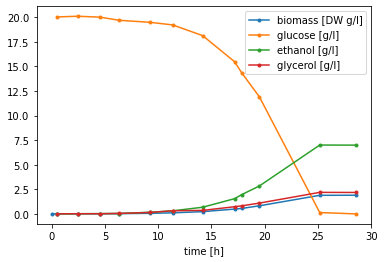

In [4]:
batch_data.plot(x='time [h]', style='.-');

To investigate where the growth is exponential, we can plot the y-axis on a logarithmic scale, if the plots are exponential the logarithmic plots will be a straight line.

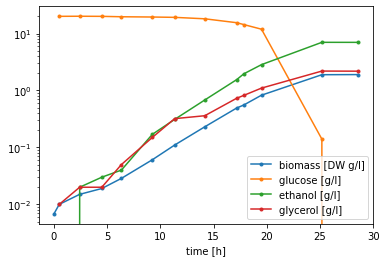

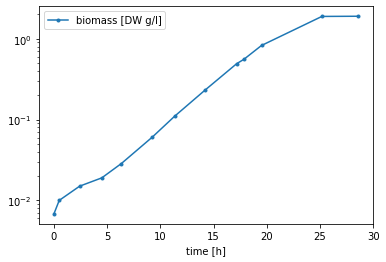

In [5]:
batch_data.plot(x='time [h]', logy = True, style='.-');
batch_data.plot(x='time [h]', y = 'biomass [DW g/l]', logy = True, style='.-');

From inspection we can see that the exponential growth phase is between 5 and 25 seconds.

In [6]:

def exp_fit(x, a, b):
    y = a * np.exp(b*x)
    return y

#Since the exponential growth does not last until the end, the last two data points are removed for the fitting to get a better fit
xdata = batch_data['time [h]'].array[4:-2]
ydata = batch_data['biomass [DW g/l]'].array[4:-2]

result = sc.optimize.curve_fit(exp_fit, xdata, ydata)[0]
u_max = result[1]
print("result:")
print(result)


result:
[0.00760486 0.24078499]


From fitting we get a value of 0.24 for $\mu_{max}$

### b) 

During exponential growth the yield coefficients should be constant. Prove it by plotting. Calculate the yield coefficients for biomass, ethanol and glycerol on glucose (Ysx, Yse, and Ysg) in g/g and in Cmol/Cmol.
Assume the generalized composition of the biomass: $CH_{1.8}O_{0.5}N_{0.2}$.

$Y = \frac{q_{product}}{q_{substrate}}$ \
The volumetric rates should have a linear relationship during the period of exponential growth. Since the data is over the same time, the concentrations are sufficient and they should also be linearly related.

This can be proven in a plot by plotting the substrate on one axis and the products on the other axis.

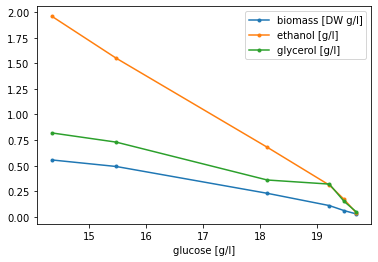

In [7]:
batch_data.iloc[4:10, 1:].plot(x='glucose [g/l]', y = ['biomass [DW g/l]', 'ethanol [g/l]', 'glycerol [g/l]'], style='.-');
#we are again only plotting the timeframe of exponential growth

The graphs show linearity, which means the yield coefficients were constant. 

The yield coefficients can be determined from this as the coefficients are how the rates are related. To do this we can fit linear functions to our graphs, the slope of these functions are the yields.

In [8]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
df = batch_data[4:10] # again, let's use only the data points of the exponential growth phase

biomass [DW g/l] 2.0063513326697957 * y -0.09935749361199336; r2 = 0.9901882229397242; MSE = 0.00042015578542678916
ethanol [g/l] 6.957147291815009 * y -0.34841362076291327; r2 = 0.9976523894280985; MSE = 0.0012269199751399817
glycerol [g/l] 2.756361309924546 * y -0.1327327863350012; r2 = 0.9495606098019909; MSE = 0.0040195990705296815


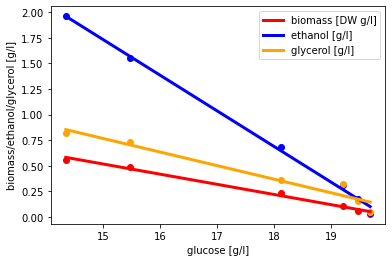

In [10]:
yields = dict() # store the fitted yield coefficients
colors = ('red', 'blue', 'orange') # colors for the plots
for i, var in enumerate(['biomass [DW g/l]', 'ethanol [g/l]', 'glycerol [g/l]']):
    reg = linear_model.LinearRegression()
    reg.fit(df[['glucose [g/l]']], df[var])       #x-axis: glucose, y-axis: product
    predicted = reg.predict(df[['glucose [g/l]']])      #predicts product quantities on basis of the fitted model/parameters
    slope = reg.coef_[0]
    intercept = reg.intercept_
    yields[var.split(" ")[0]] = -1 * slope # store the result
    r2 = r2_score(df[var], predicted)     #R^2 score of the model (should be close to 1, >0.95 generally)
    mse = mean_squared_error(df[var], predicted)     #mean squared error of the model (should be small
    print(var, f'{intercept} * y {slope}; r2 = {r2}; MSE = {mse}')
    # plot the fitted lines
    plt.scatter(df[['glucose [g/l]']], df[var],  color=colors[i])     #plot experimental data 
    plt.plot(df[['glucose [g/l]']], predicted, color=colors[i], linewidth=3, label=var)       #plot model as lines over the data points
    plt.legend()
    plt.xlabel('glucose [g/l]')
    plt.ylabel('biomass/ethanol/glycerol [g/l]')

In [11]:
C = 12.01
H = 1.008
O = 16.00
N = 14.01

molw_cmol = dict()
molw_cmol["biomass"] = C + H*1.8 + O*0.5 + N*0.2
molw_cmol["ethanol"] = (C*2 + H*5 + O + H)/2
molw_cmol["glycerol"] = (C*3 + H*8 + O*3)/3
molw_cmol["glucose"] = (C*6 + H*12 + O*6)/6
yields_cmol = dict()

for var in ['biomass [DW g/l]', 'ethanol [g/l]', 'glycerol [g/l]']:
    product = var.split(" ")[0]
    y = yields[product]
    print("yield of " + product + " [g/g] = " + str(y))
    cmoly = y * molw_cmol["glucose"]/molw_cmol[product]
    yields_cmol[product] = cmoly
    print("yield of " + product + " [cmol/cmol] = " + str(cmoly))
    

yield of biomass [g/g] = 0.09935749361199336
yield of biomass [cmol/cmol] = 0.12114268034279119
yield of ethanol [g/g] = 0.34841362076291327
yield of ethanol [cmol/cmol] = 0.45417501853899594
yield of glycerol [g/g] = 0.1327327863350012
yield of glycerol [cmol/cmol] = 0.12982717579304015


### c)

Make a C balance and calculate the yield of CO2 on glucose ($Y_{sc}$).

Glucose is the only contribution of carbon and is converted into biomass, ethanol, glycerol and CO2. This means the yields of all the products added together should add up to 1.
$Y_{sx} + Y_{se} + Y_{sg} + Y_{sc} = 1$ 
This means that $Y_{sc} = 1 - Y_{sx} - Y_{se} - Y_{sg}$

In [12]:
y_sc = 1
for var in ['biomass [DW g/l]', 'ethanol [g/l]', 'glycerol [g/l]']:
    product = var.split(" ")[0]
    y = yields_cmol[product]
    y_sc = y_sc - y

yields_cmol["co"] = y_sc
print("CO2 yield [cmol/cmol] = " + str(y_sc))

CO2 yield [cmol/cmol] = 0.2948551253251727


### d)

Using the calculated μmax and yield coefficients, calculate the specific consumption rate for glucose ($r_s$) and specific production rates for ethanol, glycerol and CO2 ($r_e$, $r_g$, and $r_c$). Use units of C-mmol/g DW·h.

The yield coefficients can also be expressed as $Y_{sx} = \frac{\mu}{r_s}$ and $Y_{sp} = \frac{r_p}{r_s}$. So we can calculate the specific rate of the substrate with $r_s = \frac{\mu}{Y_{sx}}$ and with that specific rate we can calculate the specific rates of the products with $r_p = Y_{sp} * r_s$ .

In [23]:
r_s = u_max / yields["biomass"] # g-glc gDW^-1 h^-1
print(r_s)
r_s_cmol = r_s / molw_cmol["glucose"] * 1E3
r_e = yields["ethanol"] * r_s 
r_e = r_e /molw_cmol["ethanol"] * 1E3
r_g = yields_cmol["glycerol"] * r_s
r_g = r_g / molw_cmol["glycerol"] *1E3
r_c = yields_cmol["co"] * r_s 
r_c = r_c / (12.01+2*16) * 1E3
print("specific rate glucose = " + str(r_s_cmol))
#print("specific rate biomass = " + str(r_s_cmol))
print("specific rate ethanol = " + str(r_e))
print("specific rate glycerol = " + str(r_g))
print("specific rate CO2 = " + str(r_c))

2.4234205748347177
specific rate glucose = 80.71073652283746
specific rate ethanol = 36.65680025655573
specific rate glycerol = 10.2490666815277
specific rate CO2 = 16.23626396974535
